In [51]:
import sys
sys.path.append('helpers/')

from pprint import pprint
import scipy.io as scio
from torch.utils.data import Dataset, DataLoader
from eegdProcessors import getLabeledEpochs, DownSample, BPButter4, filter_removeOutliers, Normalise
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F

In [2]:
eeg_1s_raw = scio.loadmat('./data/subject_1_eeg_separated_epochs_1s.mat')

In [3]:
len(getLabeledEpochs(eeg_1s_raw, 1/3))

1220

In [98]:
# Definiranje klase pyTorch dataseta za eeg podatke

class eegDataset(Dataset):
    labels = ('Target', 'non Target')

    def __init__(self, eeg_raw, ratio, seed, transform=None, filterChain = []):
        self.epochs = getLabeledEpochs(eeg_raw, ratio, seed=seed, filterChain=filterChain)
        self.transform = transform

    def __len__(self):
        return len(self.epochs)

    def __getitem__(self, idx):
        label = self.epochs[idx][0]
        epoch = self.epochs[idx][1]

        # Ako je dan transformer podataka
        # poslati podatke kroz njega
        if self.transform:
            epoch = self.transform(epoch)

        return torch.from_numpy(np.expand_dims(epoch, axis=0)), label

In [99]:
# Definiranje dataloadera

downsapling = 4
# Prvo se podatci downsampleaju downsapling puta
# zatim se filtriraju PP Butt filtrom 4. reda od 0.1hz do 20hz
# zatim se podatci normaliziraju po (pdf: CNN for P300 Detec... sekcija 3.1 na stranici 436)
training_data = eegDataset(eeg_1s_raw, 1/1, 'abc', transform=transforms.Compose([
    DownSample(downsapling),
    BPButter4(0.1, 20, 512/downsapling),
    Normalise()
]), filterChain=[
    filter_removeOutliers
])


train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True)

Feature batch shape: torch.Size([4, 1, 16, 128])
Labels batch shape: torch.Size([4])


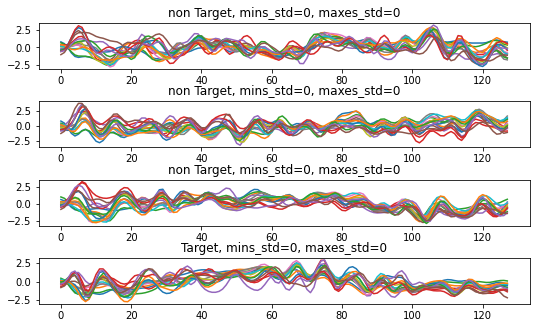

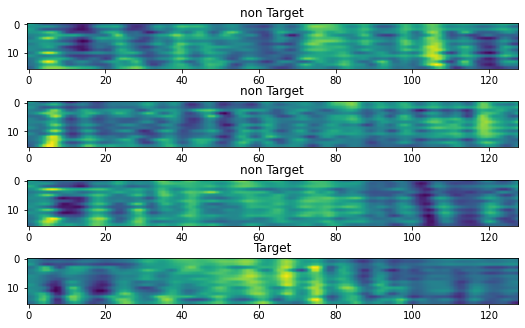

In [109]:
# Vizualizacija jednog batcha

train_ephs, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_ephs.size()}")
print(f"Labels batch shape: {train_labels.size()}")

fig2, ax2 = plt.subplots(len(train_ephs))
for key, itm in enumerate(train_ephs):
    item = itm[0]
    # Racunanje standardne devijacije maximuma i minimuma mjerenja elektroda
    mins = []
    maxes = []
    for line in item:
        ax2[key].plot(line)
        mins.append(line.min())
        maxes.append(line.max())
    mins = np.array(mins)
    maxes = np.array(maxes)
    label = training_data.labels[train_labels[key]] + ", mins_std=" + str(int(mins.std())) + ", maxes_std=" + str(int(maxes.std()))
    ax2[key].set_title(label)
    ax2[key].set_aspect('auto')

fig2.set_figwidth(2.2*len(train_ephs))
fig2.set_figheight(len(train_ephs))
fig2.subplots_adjust(top=1.1, hspace=0.7)



fig, ax = plt.subplots(len(train_ephs))
for key, itm in enumerate(train_ephs):
    item = itm[0]
    label = training_data.labels[train_labels[key]]
    ax[key].set_title(label)
    ax[key].imshow(item)
    ax[key].set_aspect('auto')

fig.set_figwidth(2.2*len(train_ephs))
fig.set_figheight(len(train_ephs))
fig.subplots_adjust(top=1.1, hspace=0.7)



In [208]:
# class EEGNet(nn.Module):
#     def __init__(self):
#         super(EEGNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 8, (1, 32), bias=False)
#         # self.pool = nn.MaxPool2d((16, 128))
#         self.conv2 = nn.Conv2d(8, 16, (6, 1))
#         self.fc1 = nn.Linear(97, 40)
#         self.fc2 = nn.Linear(40, 1)

#     def forward(self, x):
#         x = self.conv1(x.float())
#         print(x.shape)
#         x = F.elu(self.conv2(x.float()))
#         print(x.shape)
#         x = F.relu(self.fc1(x))
#         print(x.shape)
#         x = self.fc2(x)
#         print(x.shape)
        
#         return x

class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()

        self.F1 = 8
        self.F2 = 16
        self.D = 2
        
        # Conv2d(in,out,kernel,stride,padding,bias)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(self.F1)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.F1, self.D*self.F1, (8, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.D*self.F1),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )
        
        self.Conv3 = nn.Sequential(
            nn.Conv2d(self.D*self.F1, self.D*self.F1, (1, 16), padding=(0, 8), groups=self.D*self.F1, bias=False),
            nn.Conv2d(self.D*self.F1, self.F2, (1, 1), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.5)
        )
        
        self.classifier = nn.Linear(16*9*4, 2, bias=True)
        
    def forward(self, x):
        
        x = self.conv1(x.float())
        # print(x.shape)
        x = self.conv2(x.float())
        # print(x.shape)
        x = self.Conv3(x.float())
        # print(x.shape)
        
        x = x.view(-1, 16*9*4)
        # print(x.shape)
        x = self.classifier(x.float())
        # print(x.shape)
        return x

In [209]:
eegnet = EEGNet().float()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(eegnet.parameters(), lr=0.001, momentum=0.9)

In [211]:
# Treniranje

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = eegnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5 == 4:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,     5] loss: 0.001
[1,    10] loss: 0.001
[1,    15] loss: 0.001
[1,    20] loss: 0.001
[1,    25] loss: 0.001
[1,    30] loss: 0.002
[1,    35] loss: 0.001
[1,    40] loss: 0.001
[1,    45] loss: 0.002
[1,    50] loss: 0.001
[2,     5] loss: 0.001
[2,    10] loss: 0.001
[2,    15] loss: 0.001
[2,    20] loss: 0.001
[2,    25] loss: 0.001
[2,    30] loss: 0.001
[2,    35] loss: 0.001
[2,    40] loss: 0.001
[2,    45] loss: 0.001
[2,    50] loss: 0.001
Finished Training
